# 📌 NLP Text Classification Project
**Team:** Paolo, Duc, Nora, Marwane  
**Goal:** Build and evaluate multiple text classification models on a custom dataset.  
**Approaches:** ML, Neural Networks, Transformers

---

## 📁 Setup & Imports
In this step, we import all necessary Python libraries for data processing, visualization, machine learning, and NLP. This includes pandas, NumPy, matplotlib, seaborn, scikit-learn, TextBlob, XGBoost, and SMOTE from imbalanced-learn to handle class imbalance. We also prepare paths for accessing local NLTK data.

```python

In [1]:
# 📁 Setup & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import torch
import re
import os
from html import unescape
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import pickle
import textblob
from imblearn.over_sampling import SMOTE
from datasets import Dataset




## 📊 Data Loading & Initial Exploration
We load the `labeled_data.csv` file which contains labeled tweets. Then, we inspect the data using `.info()`, `.head()`, and `.isnull().sum()` to understand the structure, types, and check for missing values.

```python

In [2]:
# Define path to manually unzipped NLTK data
nltk_path = os.path.join(os.getcwd(), 'nltk_data')

# Load dataset
df = pd.read_csv("labeled_data.csv")  # or any other format

# Initial checks
df.info()
df.head()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

## 🔍 Exploratory Data Analysis (EDA)
We:
- Visualize class distribution to understand dataset imbalance.
- Analyze tweet lengths to check variability.
- Display sample tweets from each class.
- Define regex patterns for things like mentions, URLs, and emojis to assess how noisy the data is before cleaning.

```python

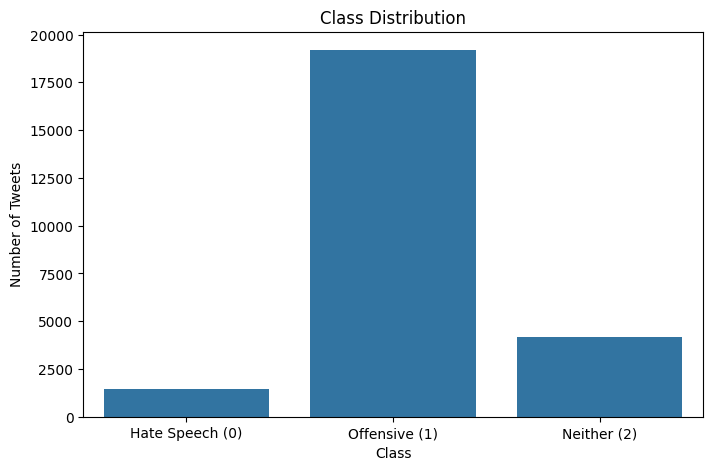

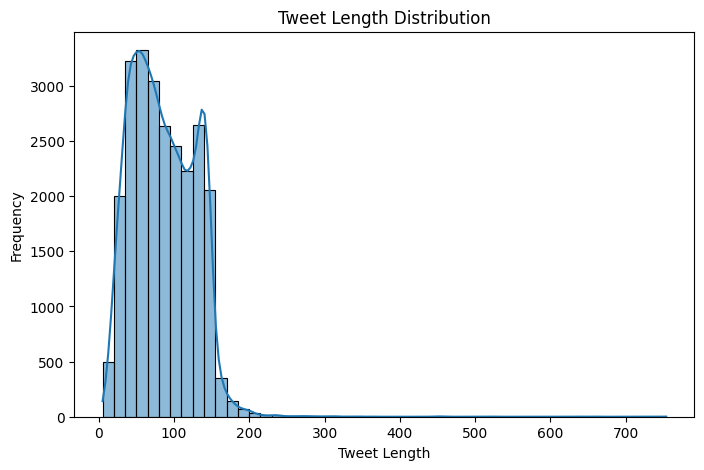


Sample tweets from class 0:
People who play #roleplayinggames are human fil...
RT @MANIAC3X: @NotoriousBM95 @Woody_AFC @_White...
                        That fucking slutty beaner

Sample tweets from class 1:
Some niggah said sugapuss to me lastnight &#128...
            @_lexisperez he ate my pussy i could..
    @ThatKid_Vicente thanks little bitch &#128526;

Sample tweets from class 2:
                     Can I double stuff your Oreo?
@TheMayorMatt @Frizzle18 I like where ur domes ...
                     @YesseSmith I was born yellow


In [3]:
# ---- STEP 2.1: Dataset Exploration ----

# Class distribution
class_counts = df['class'].value_counts().sort_index()
class_labels = ['Hate Speech (0)', 'Offensive (1)', 'Neither (2)']
plt.figure(figsize=(8,5))
sns.barplot(x=class_labels, y=class_counts.values)
plt.title("Class Distribution")
plt.ylabel("Number of Tweets")
plt.xlabel("Class")
plt.show()

# Tweet length distribution
df['tweet_length'] = df['tweet'].apply(len)
plt.figure(figsize=(8,5))
sns.histplot(df['tweet_length'], bins=50, kde=True)
plt.title("Tweet Length Distribution")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()

# Sample tweets from each class
for label in [0, 1, 2]:
    print(f"\nSample tweets from class {label}:")
    print(df[df['class'] == label]['tweet'].sample(3, random_state=1).to_string(index=False))


## 🧼 Data Cleaning
We define a `clean_tweet()` function that:
- Converts text to lowercase
- Removes mentions, URLs, hashtags, special characters
- Unescapes HTML entities
- Strips extra whitespace
This standardizes the tweet text for preprocessing.

We apply it to all tweets and validate that noise (e.g., emojis, mentions) is successfully removed.

```python

In [4]:
print("\n--- Pattern Checks in Cleaned Tweets ---")

pattern_checks = {
    "Mentions (@usernames)": r"@\w+",
    "Links (URLs)": r"http\S+|www\.\S+",
    "HTML Entities": r"&[#A-Za-z0-9]+;",
    "Emojis": r"[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+",
    "Hashtags": r"#\w+",
    "Uppercase Words": r"\b[A-Z]{2,}\b",
    "Special Characters": r"[^a-zA-Z0-9\s]"
}

# ---- STEP 2.2: Data Cleaning ----

def clean_tweet(text):
    text = text.lower()  # make lowercase
    text = re.sub(r"@\w+", "", text)  # remove @usernames
    text = re.sub(r"http\S+|www\.\S+", "", text)  # remove URLs
    text = re.sub(r"#\w+", "", text)  # remove hashtags
    text = unescape(text)  # decode HTML entities
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

# Apply cleaning
df['clean_tweet'] = df['tweet'].apply(clean_tweet)

# Show cleaned version of some tweets
print("\nBefore and after cleaning (first 5 tweets):")
for i in range(5):
    print(f"\nOriginal: {df['tweet'].iloc[i]}\nCleaned : {df['clean_tweet'].iloc[i]}")

# Re-check for patterns in cleaned data
for label, pattern in pattern_checks.items():
    count = df['clean_tweet'].str.contains(pattern, regex=True).sum()
    print(f"{label} (after cleaning): {count} tweets")



--- Pattern Checks in Cleaned Tweets ---

Before and after cleaning (first 5 tweets):

Original: !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
Cleaned : rt as a woman you shouldnt complain about cleaning up your house as a man you should always take the trash out

Original: !!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
Cleaned : rt boy dats coldtyga dwn bad for cuffin dat hoe in the 1st place

Original: !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
Cleaned : rt dawg rt you ever fuck a bitch and she start to cry you be confused as shit

Original: !!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
Cleaned : rt she look like a tranny

Original: !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to y

## 🧽 Text Preprocessing
We use NLTK’s lemmatizer and manually loaded tokenizer to:
- Tokenize each tweet
- Remove stopwords
- Lemmatize remaining words
The final cleaned version (`processed_tweet`) is normalized, tokenized, and semantically simplified.

```python

In [5]:
# ---- STEP 2.3: Text Preprocessing ----

import pickle
from nltk.stem import WordNetLemmatizer

# Load stopwords manually from actual file path
stopwords_path = os.path.join(nltk_path, 'corpora', 'stopwords', 'english')
with open(stopwords_path, 'r', encoding='utf-8') as f:
    stop_words = set(f.read().split())

lemmatizer = WordNetLemmatizer()

tokenizer_path = os.path.join(nltk_path, "tokenizers", "punkt", "english.pickle")
with open(tokenizer_path, "rb") as f:
    word_tokenizer = pickle.load(f)

def preprocess(text):
    tokens = word_tokenizer.tokenize(text)  # use manually loaded tokenizer
    tokens = [t for t in tokens if t not in stop_words]  # remove stopwords
    tokens = [lemmatizer.lemmatize(t) for t in tokens]  # lemmatize
    return ' '.join(tokens)

# Apply preprocessing
df['processed_tweet'] = df['clean_tweet'].apply(preprocess)

# Show example results
print("\nCleaned vs. Processed Tweets (first 5):")
for i in range(5):
    print(f"\nCleaned   : {df['clean_tweet'].iloc[i]}\nProcessed : {df['processed_tweet'].iloc[i]}")


Cleaned vs. Processed Tweets (first 5):

Cleaned   : rt as a woman you shouldnt complain about cleaning up your house as a man you should always take the trash out
Processed : rt as a woman you shouldnt complain about cleaning up your house as a man you should always take the trash out

Cleaned   : rt boy dats coldtyga dwn bad for cuffin dat hoe in the 1st place
Processed : rt boy dats coldtyga dwn bad for cuffin dat hoe in the 1st place

Cleaned   : rt dawg rt you ever fuck a bitch and she start to cry you be confused as shit
Processed : rt dawg rt you ever fuck a bitch and she start to cry you be confused as shit

Cleaned   : rt she look like a tranny
Processed : rt she look like a tranny

Cleaned   : rt the shit you hear about me might be true or it might be faker than the bitch who told it to ya
Processed : rt the shit you hear about me might be true or it might be faker than the bitch who told it to ya


## 🏗️ Feature Engineering
We add extra features to enrich model input:
- Text-based: word count, average word length
- Style-based: number of uppercase words, exclamations, hashtags, mentions, links
- Sentiment-based: polarity and subjectivity scores from TextBlob
These features complement the textual representation.

```python

In [6]:
# ---- Feature Engineering ----
df['word_count'] = df['clean_tweet'].apply(lambda x: len(x.split()))
df['avg_word_length'] = df['clean_tweet'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)
df['num_uppercase'] = df['tweet'].apply(lambda x: sum(1 for w in x.split() if w.isupper()))
df['num_exclaims'] = df['tweet'].str.count('!')
df['num_hashtags'] = df['tweet'].str.count(r"#\w+")
df['num_mentions'] = df['tweet'].str.count(r"@\w+")
df['num_links'] = df['tweet'].str.count(r"http\S+|www\.\S+")
df['polarity'] = df['clean_tweet'].apply(lambda x: textblob.TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['clean_tweet'].apply(lambda x: textblob.TextBlob(x).sentiment.subjectivity)

# ---- Feature Extraction ----
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df['processed_tweet'])

numeric_features = ['tweet_length', 'word_count', 'avg_word_length', 'num_uppercase',
                    'num_exclaims', 'num_hashtags', 'num_mentions', 'num_links',
                    'polarity', 'subjectivity']
scaler = StandardScaler()
X_numeric = scaler.fit_transform(df[numeric_features])
X = hstack([X_text, X_numeric])
y = df['class']


## ⚖️ Handle Class Imbalance with SMOTE
We use SMOTE to generate synthetic samples for minority classes, creating a balanced dataset before train-test splitting (80/20 split).

```python

In [7]:
# 1) Split before SMOTE to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# 2) Apply SMOTE only on the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

## 🤖 Model Training & Evaluation
We train and evaluate 3 models:


In [8]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_res, y_train_res)
print("--- Logistic Regression ---")
y_pred_lr = lr_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.53      0.39       286
           1       0.96      0.86      0.91      3838
           2       0.76      0.92      0.84       833

    accuracy                           0.85      4957
   macro avg       0.68      0.77      0.71      4957
weighted avg       0.89      0.85      0.87      4957

Confusion Matrix:
[[ 153  101   32]
 [ 325 3305  208]
 [  21   42  770]]


In [9]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100,
                                  random_state=42,
                                  class_weight='balanced')
rf_model.fit(X_train_res, y_train_res)

print("--- Random Forest ---")
y_pred_rf = rf_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

--- Random Forest ---
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.20      0.29       286
           1       0.89      0.95      0.92      3838
           2       0.79      0.71      0.75       833

    accuracy                           0.87      4957
   macro avg       0.73      0.62      0.65      4957
weighted avg       0.85      0.87      0.86      4957

Confusion Matrix:
[[  57  200   29]
 [  53 3659  126]
 [   2  239  592]]


In [10]:
xgb_model = XGBClassifier(use_label_encoder=False,
                          eval_metric='mlogloss')
xgb_model.fit(X_train_res, y_train_res)
print("--- XGBoost ---")
y_pred_xgb = xgb_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


C:\Users\mchat\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:13:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost ---
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.32      0.38       286
           1       0.95      0.93      0.94      3838
           2       0.79      0.94      0.85       833

    accuracy                           0.90      4957
   macro avg       0.74      0.73      0.72      4957
weighted avg       0.89      0.90      0.89      4957

Confusion Matrix:
[[  92  156   38]
 [  97 3566  175]
 [   5   49  779]]


In [11]:
import os
# Disable GPU to ensure training only uses CPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
import torch
import numpy as np
import re
import textblob
from scipy.sparse import hstack

## . Data Preparation
Load your dataframe `df` and prepare a Hugging Face `Dataset` from processed tweets.

In [12]:
# Assuming `df` is already loaded with `processed_tweet` and `class` columns
bert_df = df[['processed_tweet', 'class']].rename(columns={'processed_tweet':'text','class':'labels'})
dataset = Dataset.from_pandas(bert_df)
dataset = dataset.train_test_split(test_size=0.2, seed=42)


## . Tokenization
Use `DistilBertTokenizerFast` to tokenize tweets with padding and truncation.

In [13]:
# --- Tokenization ---
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
def tokenize_function(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# --- Directories ---
train_output_dir = './results'
fine_tuned_dir = './distilbert-finetuned'

Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

## . Model & Trainer Setup
Initialize `DistilBertForSequenceClassification` and configure `Trainer`.

In [26]:
# --- Model & Trainer Setup ---


model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
training_args = TrainingArguments(
    output_dir=train_output_dir,
    overwrite_output_dir=True,    # ← this wipes ./results before each run
    per_device_train_batch_size=8,
    num_train_epochs=5,
    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_steps=100,
    logging_steps=50,
    fp16=False,
    no_cuda=True,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
import torch
import torch.nn as nn

# Match these counts to your training split distribution
counts = torch.tensor([260, 3839, 858], dtype=torch.float)
weights = counts.sum() / (3 * counts)
weights = weights.to('cpu')   # since no_cuda=True

loss_fn = nn.CrossEntropyLoss(weight=weights)

In [30]:
# ─── NEW: subclass Trainer to override compute_loss ─────────────────────────
from transformers import Trainer

class WeightedTrainer(Trainer):
    def compute_loss(self,
                     model,
                     inputs,
                     return_outputs: bool = False,
                     **kwargs):      # accept any extra args
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss
# ─── REPLACE your vanilla Trainer with this ─────────────────────────────────
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
)

## . Training & Evaluation
Train the model and evaluate on the test split.

In [32]:
# --- Train or Load  ---
if not os.path.isdir(fine_tuned_dir):
    print(f"Checkpoint not found in {fine_tuned_dir}. Starting training on CPU...")
    trainer.train()
    trainer.evaluate()
    trainer.save_model(fine_tuned_dir)
    tokenizer.save_pretrained(fine_tuned_dir)
else:
    print(f"Loading fine-tuned model from {fine_tuned_dir} (CPU)...")
    model = DistilBertForSequenceClassification.from_pretrained(fine_tuned_dir)
    tokenizer = DistilBertTokenizerFast.from_pretrained(fine_tuned_dir)


Checkpoint not found in ./distilbert-finetuned. Starting training on CPU...


Step,Training Loss
50,0.556800
100,0.586200
150,0.595100
200,0.521300
250,0.551400
300,0.454500
350,0.583700
400,0.476700
450,0.427900
500,0.724100


In [33]:
pred_out = trainer.predict(tokenized_dataset["test"])
pred_labels = pred_out.predictions.argmax(axis=-1)
true_labels = pred_out.label_ids

print("--- DistilBERT ---")
print("Classification Report:")
print(classification_report(true_labels, pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

--- DistilBERT ---
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.36      0.39       260
           1       0.94      0.95      0.94      3839
           2       0.89      0.88      0.89       858

    accuracy                           0.91      4957
   macro avg       0.75      0.73      0.74      4957
weighted avg       0.90      0.91      0.91      4957

Confusion Matrix:
[[  93  149   18]
 [ 117 3651   71]
 [   9   94  755]]


## . Classical ML Predict Function
Define a function using a trained Random Forest (`rf_model`) and TF-IDF + numeric features.

In [19]:
# --- Classical ML Predict Function ---
# Accept model, vectorizer, scaler as arguments
def predict_tweet_classical(text, model, vectorizer, scaler):
    # Clean and preprocess
    cleaned = clean_tweet(text)
    processed = preprocess(cleaned)
    # Text features
    X_text = vectorizer.transform([processed])
    # Numeric features
    tweet_length = len(text)
    word_count = len(cleaned.split())
    avg_word_length = np.mean([len(w) for w in cleaned.split()]) if cleaned.split() else 0
    num_uppercase = sum(1 for w in text.split() if w.isupper())
    num_exclaims = text.count('!')
    num_hashtags = len(re.findall(r"#\w+", text))
    num_mentions = len(re.findall(r"@\w+", text))
    num_links = len(re.findall(r"http\S+|www\.\S+", text))
    polarity = textblob.TextBlob(cleaned).sentiment.polarity
    subjectivity = textblob.TextBlob(cleaned).sentiment.subjectivity
    X_numeric = np.array([[
        tweet_length, word_count, avg_word_length, num_uppercase,
        num_exclaims, num_hashtags, num_mentions, num_links,
        polarity, subjectivity
    ]])
    X_numeric_scaled = scaler.transform(X_numeric)
    # Combine
    X_combined = hstack([X_text, X_numeric_scaled])
    pred = model.predict(X_combined)[0]
    return {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}[pred]

## . Transformer Predict Function
Define a function to predict with the fine-tuned DistilBERT model.

In [20]:
# --- Transformer Predict Function ---
def predict_tweet_transformer(text, model, tokenizer):
    model.eval()
    cleaned = clean_tweet(text)
    processed = preprocess(cleaned)
    inputs = tokenizer(processed, return_tensors='pt', truncation=True,
                       padding='max_length', max_length=128)
    with torch.no_grad():
        logits = model(**inputs).logits
    pred = torch.argmax(logits, dim=-1).item()
    return {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}[pred]

## . Example Usage
Test both prediction functions on sample tweets.

In [21]:
# Define example tweets with expected classes as comments
examples = [
    "I hate Muslims and want them out of our country.",         # Hate Speech
    "You are such an idiot, get a life!",                       # Offensive Language
    "Check out my new blog post at http://myblog.com",         # Neither
    "Happy birthday @alice! Hope you have a wonderful day!",   # Neither
    "I fucking love this game, it’s awesome."                  # Offensive Language
]

for tweet in examples:
    print(f"Tweet: {tweet}")
    print(" → Classical RF:", predict_tweet_classical(tweet, rf_model, vectorizer, scaler))
    print(" → Transformer:", predict_tweet_transformer(tweet, model, tokenizer))
    print()


Tweet: I hate Muslims and want them out of our country.
 → Classical RF: Offensive Language


C:\Users\mchat\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


 → Transformer: Hate Speech

Tweet: You are such an idiot, get a life!
 → Classical RF: Offensive Language
 → Transformer: Offensive Language

Tweet: Check out my new blog post at http://myblog.com
 → Classical RF: Offensive Language
 → Transformer: Neither

Tweet: Happy birthday @alice! Hope you have a wonderful day!
 → Classical RF: Offensive Language
 → Transformer: Neither

Tweet: I fucking love this game, it’s awesome.
 → Classical RF: Offensive Language


C:\Users\mchat\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mchat\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mchat\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mchat\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


 → Transformer: Offensive Language

